# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
import missingno as msno

# Train-test splits
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV

# Model preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from patsy import dmatrices

# Modeling
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from itertools import combinations
from scipy.stats import uniform, randint

# Model metrics and analysis
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn import metrics

# Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# Load the data

In [2]:
from vega_datasets import data

cars = data.cars()

df = cars[['Name', 'Miles_per_Gallon', 'Displacement', 'Horsepower', 'Origin']].copy()

## Explore the contents of the data sets

In [3]:
df.head()

,Name,Miles_per_Gallon,Displacement,Horsepower,Origin
0,chevrolet chevelle malibu,18.0,307.0,130.0,USA
1,buick skylark 320,15.0,350.0,165.0,USA
2,plymouth satellite,18.0,318.0,150.0,USA
3,amc rebel sst,16.0,304.0,150.0,USA
4,ford torino,17.0,302.0,140.0,USA


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              406 non-null    object 
 1   Miles_per_Gallon  398 non-null    float64
 2   Displacement      406 non-null    float64
 3   Horsepower        400 non-null    float64
 4   Origin            406 non-null    object 
dtypes: float64(3), object(2)
memory usage: 16.0+ KB


`Miles_per_Gallon` and `Horsepower` have missing values, but not many.

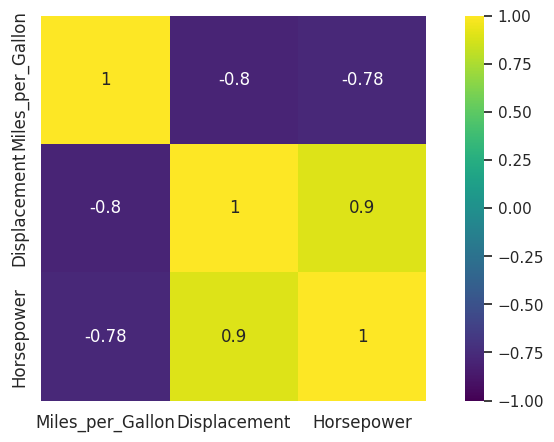

In [5]:
corr_matrix = df.drop(columns = ['Name', 'Origin']).corr()

plt.figure(figsize=(10,5))

sns.heatmap(corr_matrix, vmax=1, vmin=-1, square=True, annot=True, cmap='viridis')

plt.tick_params(labelsize=12);

There is a high correlation between the numerical predictors and the response variable. This alone suggests there is something worthwhile to explore in the data.

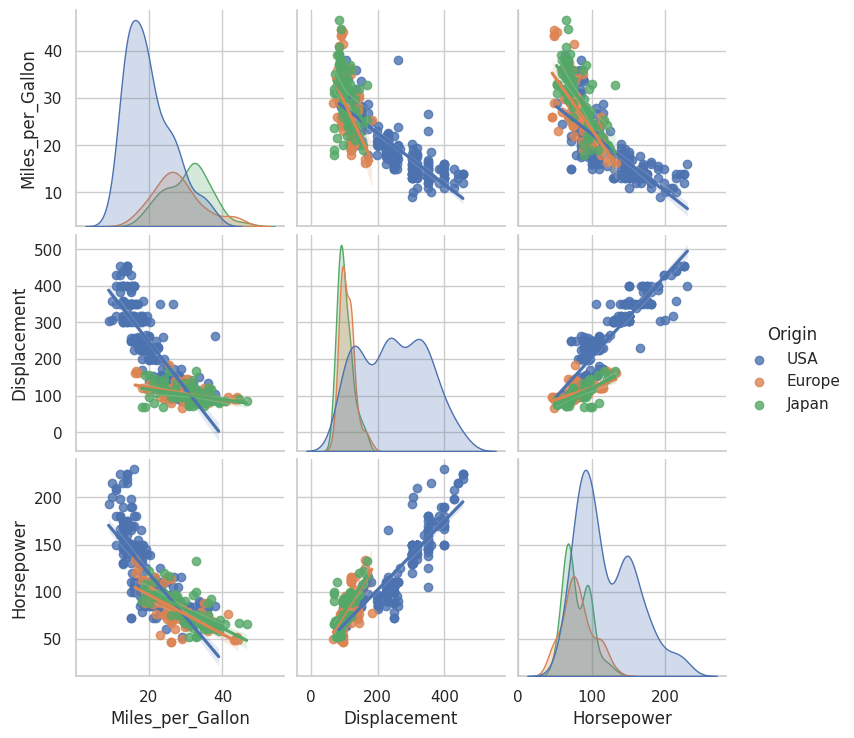

In [6]:
sns.pairplot(data=df, hue='Origin', kind='reg');


# Data preparation

### Quality control

In [7]:
df.describe()

,Miles_per_Gallon,Displacement,Horsepower
count,398.000000,406.000000,400.000000
mean,23.514573,194.779557,105.082500
std,7.815984,104.922458,38.768779
min,9.000000,68.000000,46.000000
25%,17.500000,105.000000,75.750000
50%,23.000000,151.000000,95.000000
75%,29.000000,302.000000,130.000000
max,46.600000,455.000000,230.000000


In [8]:
df.drop(columns=['Name', 'Origin']).agg(['min', 'max']).round(2)

,Miles_per_Gallon,Displacement,Horsepower
min,9.0,68.0,46.0
max,46.6,455.0,230.0


There are no obviously out-of-range values.

To check the values of the categorical variable `Origin` to see if there are any misspellings or unexpected values.

In [9]:
df['Origin'].value_counts()

,count
Origin,
USA,254
Japan,79
Europe,73


To check for any duplicated rows

In [10]:
df.duplicated().sum()

2

In [11]:
df[df.duplicated(keep=False)]

,Name,Miles_per_Gallon,Displacement,Horsepower,Origin
24,datsun pl510,27.0,97.0,88.0,Japan
35,datsun pl510,27.0,97.0,88.0,Japan
47,ford galaxie 500,14.0,351.0,153.0,USA
72,ford galaxie 500,14.0,351.0,153.0,USA


Dropping any duplicate rows .

In [12]:
df.drop_duplicates(inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404 entries, 0 to 405
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              404 non-null    object 
 1   Miles_per_Gallon  396 non-null    float64
 2   Displacement      404 non-null    float64
 3   Horsepower        398 non-null    float64
 4   Origin            404 non-null    object 
dtypes: float64(3), object(2)
memory usage: 18.9+ KB


### Transform categorical variables

In [14]:
pd.get_dummies(df['Origin'], drop_first=True)

,Japan,USA
0,False,True
1,False,True
2,False,True
3,False,True
4,False,True
...,...,...
401,False,True
402,False,False
403,False,True
404,False,True


Adding the dummies to the data frame

In [15]:
df = df.join(pd.get_dummies(df['Origin'], drop_first=True))

In [16]:
df.head()

,Name,Miles_per_Gallon,Displacement,Horsepower,Origin,Japan,USA
0,chevrolet chevelle malibu,18.0,307.0,130.0,USA,False,True
1,buick skylark 320,15.0,350.0,165.0,USA,False,True
2,plymouth satellite,18.0,318.0,150.0,USA,False,True
3,amc rebel sst,16.0,304.0,150.0,USA,False,True
4,ford torino,17.0,302.0,140.0,USA,False,True


Renaming the columns to follow best practices

In [17]:
df.rename(columns=str.lower, inplace=True)

df.head()

,name,miles_per_gallon,displacement,horsepower,origin,japan,usa
0,chevrolet chevelle malibu,18.0,307.0,130.0,USA,False,True
1,buick skylark 320,15.0,350.0,165.0,USA,False,True
2,plymouth satellite,18.0,318.0,150.0,USA,False,True
3,amc rebel sst,16.0,304.0,150.0,USA,False,True
4,ford torino,17.0,302.0,140.0,USA,False,True


## Identify missing values

In [18]:
df.isna().sum()

,0
name,0
miles_per_gallon,8
displacement,0
horsepower,6
origin,0
japan,0
usa,0


Percentage of values of each variable that are missing

In [19]:
df.isna().mean().round(4)*100

,0
name,0.00
miles_per_gallon,1.98
displacement,0.00
horsepower,1.49
origin,0.00
japan,0.00
usa,0.00


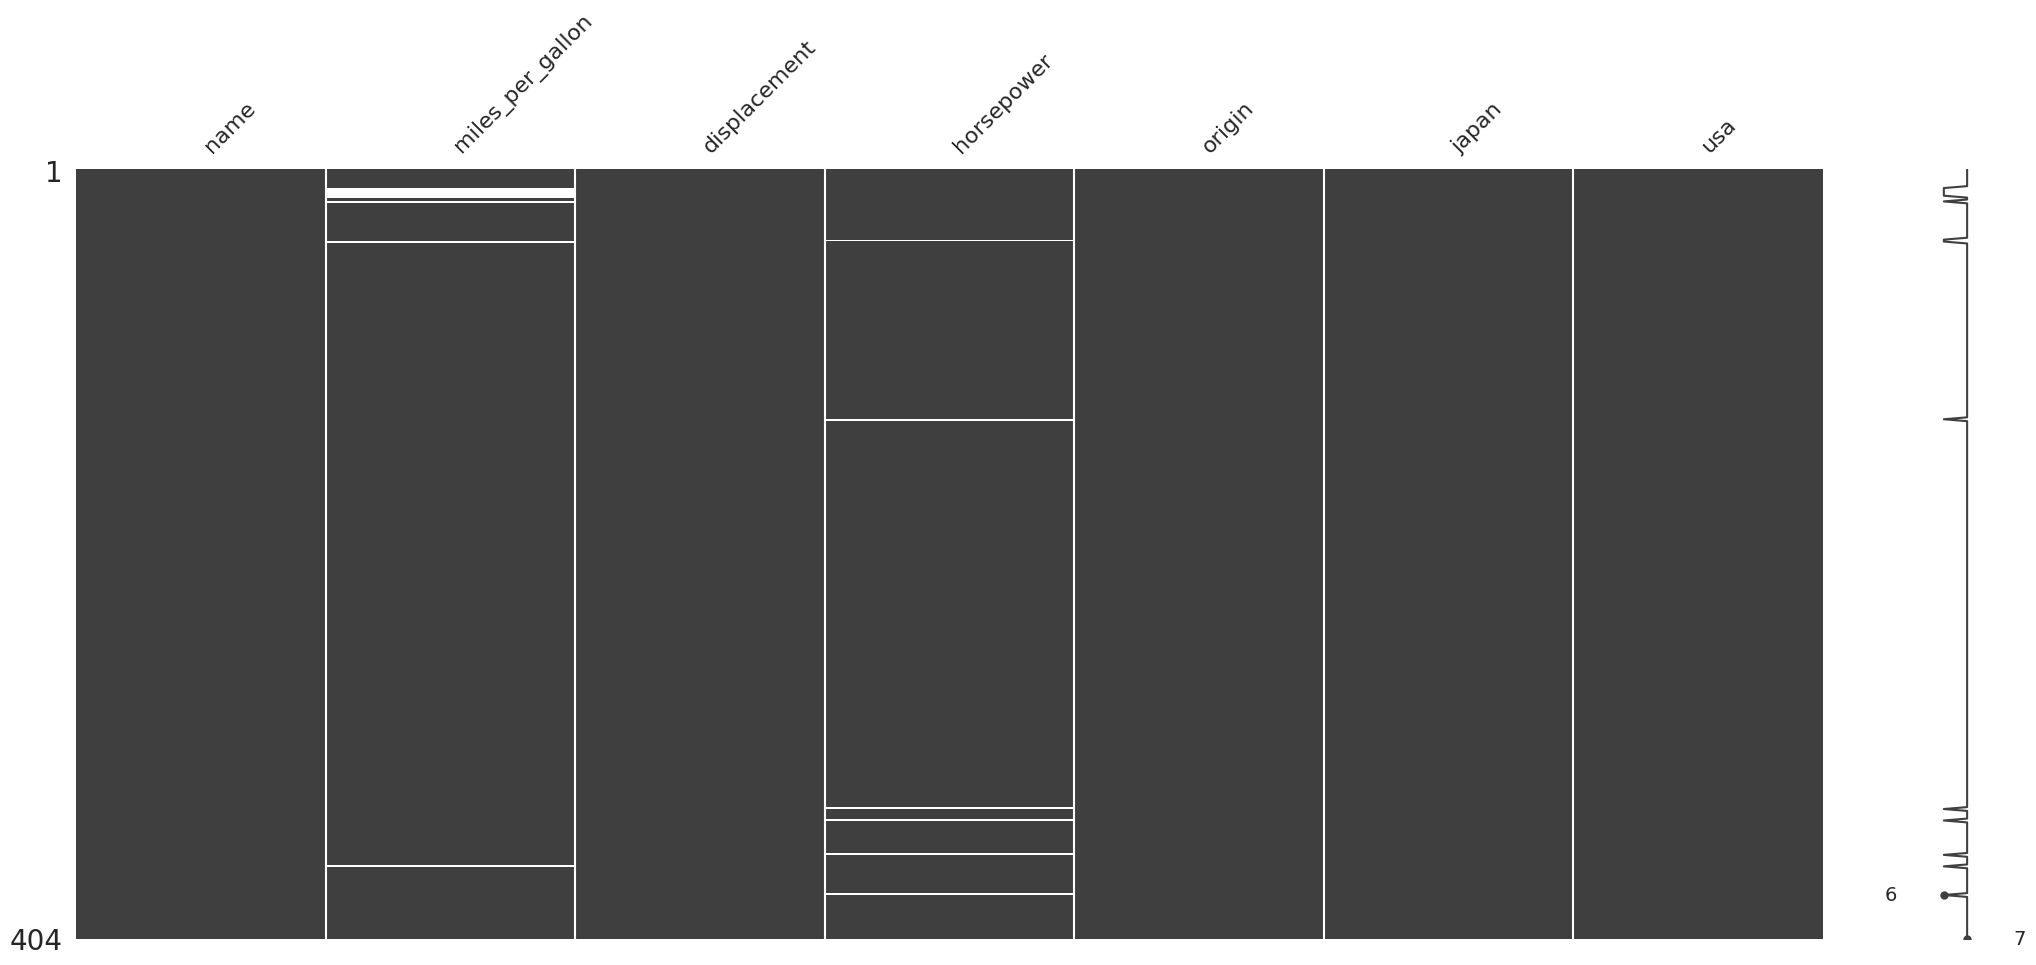

In [20]:
msno.matrix(df);

There are missing values, but not too many.


In [21]:
df = df.dropna(subset=['miles_per_gallon'])

In [22]:
df.isna().sum()

,0
name,0
miles_per_gallon,0
displacement,0
horsepower,6
origin,0
japan,0
usa,0


## Train test split

#### TO get input and output variables.

In [23]:
df.head(1)

,name,miles_per_gallon,displacement,horsepower,origin,japan,usa
0,chevrolet chevelle malibu,18.0,307.0,130.0,USA,False,True


In [24]:
X = df.drop(columns = ['name', 'miles_per_gallon'])

y = df['miles_per_gallon']

In [25]:
X.head()

,displacement,horsepower,origin,japan,usa
0,307.0,130.0,USA,False,True
1,350.0,165.0,USA,False,True
2,318.0,150.0,USA,False,True
3,304.0,150.0,USA,False,True
4,302.0,140.0,USA,False,True


In [26]:
y.head()

,miles_per_gallon
0,18.0
1,15.0
2,18.0
3,16.0
4,17.0


#### Train and test splits

Splitting the data into training and testing sets. Keeping 20% of the data for the test set.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 100)

In [28]:
print(X_train.shape, X_test.shape)

(316, 5) (80, 5)


### Scale the numerical predictor variables in the training set to have mean 0 and standard deviation 1.

Getting the names of the numerical predictor variables whose values have to be normalized.

In [29]:
numerical_columns = ['displacement', 'horsepower']



In [30]:
scaler = StandardScaler().fit(X_train[numerical_columns])

Performing the scaling transform on the predictors in the training and testing sets.

In [31]:
X_train[numerical_columns] = scaler.transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

Checking the mean and standard deviation of the transformed data.

In [32]:
print(np.mean(X_train[numerical_columns], axis = 0).round(2))
print(np.std(X_train[numerical_columns], axis = 0))

print(np.mean(X_test[numerical_columns], axis = 0).round(2))
print(np.std(X_test[numerical_columns], axis = 0).round(2))

displacement    0.0
horsepower      0.0
dtype: float64
displacement    1.0
horsepower      1.0
dtype: float64
displacement   -0.26
horsepower     -0.20
dtype: float64
displacement    0.86
horsepower      0.83
dtype: float64


#### Imputation

In [33]:
imputer = IterativeImputer()

Fitting the imputer using the training data only.

In [34]:
X_train.head()

,displacement,horsepower,origin,japan,usa
145,1.121011,1.110412,USA,False,True
197,1.431488,1.160889,USA,False,True
257,1.121011,0.858027,USA,False,True
33,1.121011,2.624720,USA,False,True
358,-0.948832,-1.034859,USA,False,True


In [35]:
impute_columns = ['displacement', 'horsepower', 'japan', 'usa']

To fit the imputer

In [36]:
imputer.fit(X_train.loc[:, impute_columns])

IterativeImputer()

To impute the missing values in the training data.

In [37]:
X_train.loc[:, impute_columns] = imputer.transform(X_train.loc[:, impute_columns])

To check for missing values

In [38]:
X_train.isna().sum()

,0
displacement,0
horsepower,0
origin,0
japan,0
usa,0


To check for missing values in the test data

In [39]:
X_test.isna().sum()

,0
displacement,0
horsepower,1
origin,0
japan,0
usa,0


In [40]:
X_test.loc[:, impute_columns] = imputer.transform(X_test.loc[:, impute_columns])

To check for missing values.

In [41]:
X_test.isna().sum()

,0
displacement,0
horsepower,0
origin,0
japan,0
usa,0


In [42]:
df_train = X_train.join(y_train)

In [43]:
df_train.head()

,displacement,horsepower,origin,japan,usa,miles_per_gallon
145,1.121011,1.110412,USA,0.0,1.0,14.0
197,1.431488,1.160889,USA,0.0,1.0,14.5
257,1.121011,0.858027,USA,0.0,1.0,19.4
33,1.121011,2.624720,USA,0.0,1.0,11.0
358,-0.948832,-1.034859,USA,0.0,1.0,34.4


In [44]:
df_test = X_test.join(y_test)

In [45]:
df_test.head()

,displacement,horsepower,origin,japan,usa,miles_per_gallon
382,-0.450188,-0.572970,USA,0.0,1.0,23.0
376,-0.817115,-0.454374,USA,0.0,1.0,27.0
212,-0.958240,-0.782474,Japan,1.0,0.0,28.0
398,-0.516047,-0.252466,Japan,1.0,0.0,32.0
356,-1.014690,-0.959143,Japan,1.0,0.0,34.1


# Exploratory data analysis

### Examine distributions and relationships

Plot of the correlation matrix of the numerical variables in the training data to explore relationships between the variables.

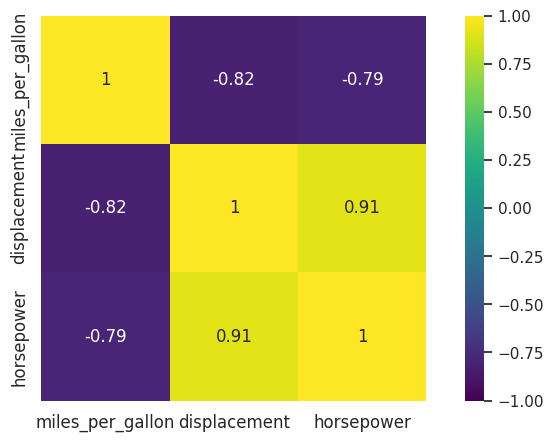

In [46]:
corr_matrix = df_train[['miles_per_gallon', 'displacement', 'horsepower']].corr()

plt.figure(figsize=(10,5))

sns.heatmap(corr_matrix, vmax=1, vmin=-1, square=True, annot=True, cmap='viridis')

plt.tick_params(labelsize=12);

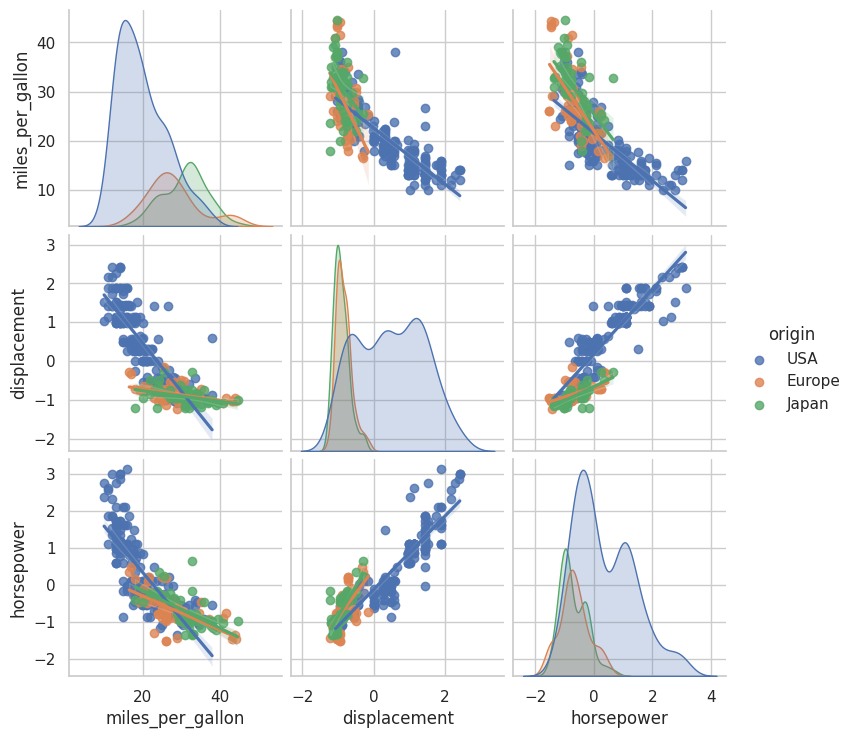

In [47]:
sns.pairplot(data=df_train,
             vars=['miles_per_gallon', 'displacement', 'horsepower'],
             hue='origin',
             kind='reg');

Use of the interquartile range to identify outliers.

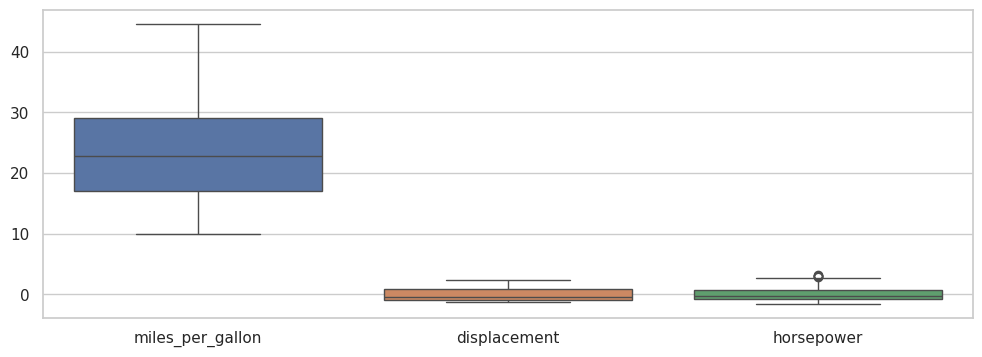

In [48]:
plt.figure(figsize=(12,4))
sns.boxplot(data=df_train[['miles_per_gallon', 'displacement', 'horsepower']]);

A few observations:

1.  `displacement` and `horsepower` are clearly related to `miles_per_gallon`.
2.  There is an overall nonlinear relationship between each of the predictors `displacement`, `horsepower`, and `miles_per_gallon`, but the strength of the nonlinearity might vary between values of `origin`.
3.  `displacement` and `horsepower` are highly correlated, so we might not need both predictors in a model.
4.  The individual distributions do not appear to have radical outliers or high skew.

# Modeling

### Baseline models

Creating design matrices for training and testing data for multiple models.

In [49]:
def design_matrices(formula, df_train, df_test):

    _, X_design_train = dmatrices(formula,
                                  data=df_train,
                                  return_type='dataframe')

    _, X_design_test = dmatrices(formula,
                                 data=df_test,
                                 return_type='dataframe')

    return X_design_train, X_design_test

#### Multiple linear regression

Creating the input (design) matrices for the training and testing data for a model where `displacement` and `horsepower` appear as linear predictors, with an interaction with `origin`.

In [50]:
X_design_train, X_design_test = design_matrices('miles_per_gallon ~(displacement +  horsepower) * C(origin)', df_train, df_test)

In [51]:
X_design_train.head()

,Intercept,C(origin)[T.Japan],C(origin)[T.USA],displacement,displacement:C(origin)[T.Japan],displacement:C(origin)[T.USA],horsepower,horsepower:C(origin)[T.Japan],horsepower:C(origin)[T.USA]
145,1.0,0.0,1.0,1.121011,0.0,1.121011,1.110412,0.0,1.110412
197,1.0,0.0,1.0,1.431488,0.0,1.431488,1.160889,0.0,1.160889
257,1.0,0.0,1.0,1.121011,0.0,1.121011,0.858027,0.0,0.858027
33,1.0,0.0,1.0,1.121011,0.0,1.121011,2.624720,0.0,2.624720
358,1.0,0.0,1.0,-0.948832,-0.0,-0.948832,-1.034859,-0.0,-1.034859


Fit the model.

In [52]:
model = sm.OLS(y_train, X_design_train).fit()

Print the summary

In [53]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       miles_per_gallon   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     115.5
Date:                Wed, 25 Sep 2024   Prob (F-statistic):           6.70e-88
Time:                        22:31:03   Log-Likelihood:                -878.76
No. Observations:                 316   AIC:                             1776.
Df Residuals:                     307   BIC:                             1809.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [54]:
y_hat = model.predict(X_design_train)

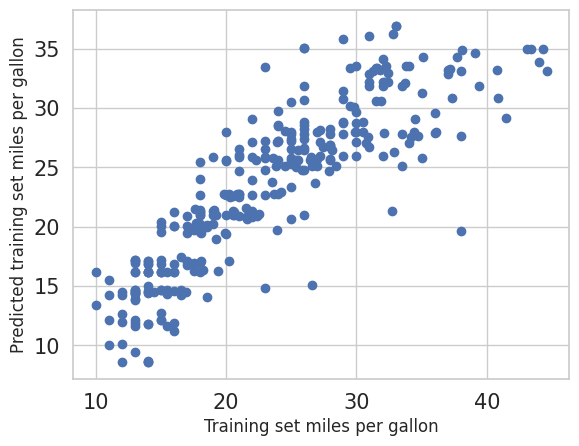

In [55]:
plt.plot(y_train, y_hat, 'o')

plt.xlabel('Training set miles per gallon', fontsize = 12)
plt.ylabel('Predicted training set miles per gallon', fontsize = 12)

plt.tick_params(labelsize = 15);

There are no dramatic outliers, but there are a few points outside the main group.

Predicting `y` in the test data and assessing the accuracy of the prediction.

In [56]:
y_predict_lr = model.predict(X_design_test)

Plot of the test values of `y` vs. the predicted values

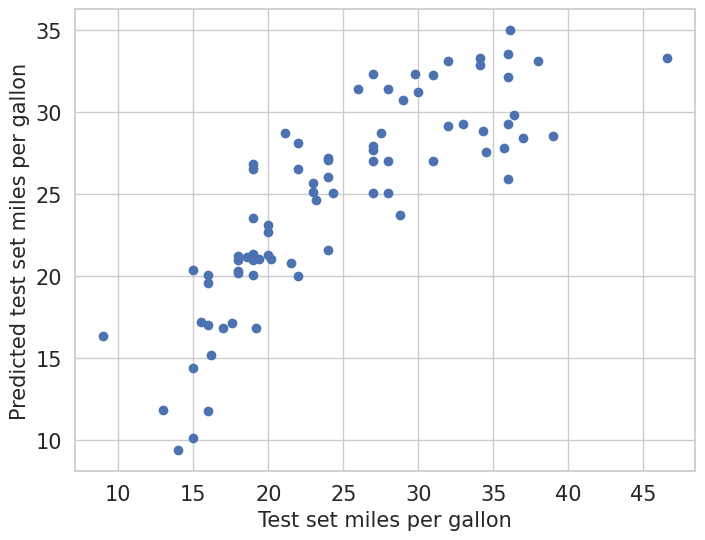

In [57]:
plt.figure(figsize = (8,6))

plt.plot(y_test, y_predict_lr, 'o');

plt.xlabel('Test set miles per gallon', fontsize = 15)
plt.ylabel('Predicted test set miles per gallon', fontsize = 15)

plt.tick_params(labelsize = 15)

Again we observe a nonlinear relationship between the model and the data.

To compute the RMSE

In [58]:
mean_squared_error(y_test, y_predict_lr, squared = False).round(3)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


4.288

To compute the mean absolute error

In [59]:
mean_absolute_error(y_test, y_predict_lr).round(3)

3.383

This says that we can predict miles per gallon with an average error of roughly 3.4 miles per gallon using these predictors.

#### Random forest

In [60]:
rf_model = RandomForestRegressor()

params = {
    "max_depth": randint(2, 18),
    "n_estimators": randint(80, 150),
    "min_samples_leaf": randint(1, 8)
}

search = RandomizedSearchCV(rf_model,
                            param_distributions=params,
                            n_iter=50, # Ideally, this would be larger, but it takes a long time
                            cv=5,# no. of pieces to break data into
                            verbose=1,
                            n_jobs=1,
                            return_train_score=True,
                            scoring = 'neg_mean_squared_error')


search.fit(X_train.drop(columns='origin'), y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=50, n_jobs=1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b2b88244430>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b2b881f81f0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b2b85f23430>},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

The best parameters are:

In [61]:
search.best_params_

{'max_depth': 14, 'min_samples_leaf': 4, 'n_estimators': 125}

Creating a random forest regression model object with these parameters

In [62]:
model_rf = RandomForestRegressor(**search.best_params_)

Fitting the model with the training data

In [63]:
model_rf.fit(X_train.drop(columns='origin'), y_train)

RandomForestRegressor(max_depth=14, min_samples_leaf=4, n_estimators=125)

Plot the test values of `y` vs. the predicted values

In [64]:
y_predict_rf = model_rf.predict(X_test.drop(columns='origin'))

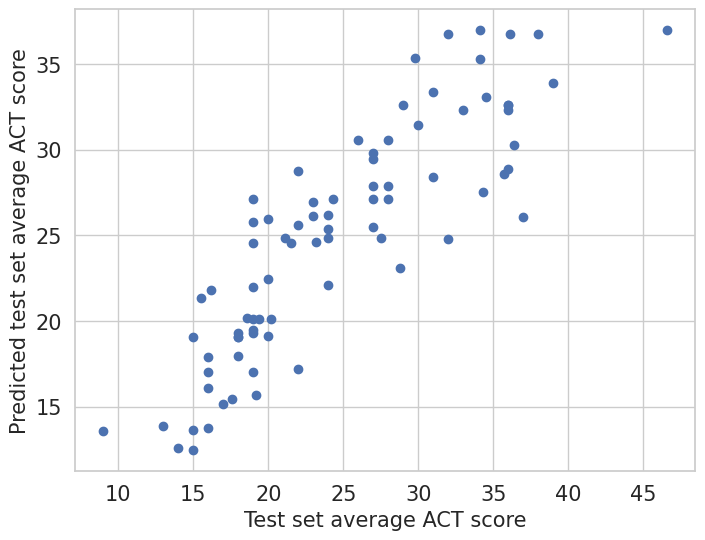

In [65]:
plt.figure(figsize = (8,6))

plt.plot(y_test, y_predict_rf, 'o');

plt.xlabel('Test set average ACT score', fontsize = 15)
plt.ylabel('Predicted test set average ACT score', fontsize = 15)

plt.tick_params(labelsize = 15)

In [66]:
r_squared = r2_score(y_test, y_predict_rf)

# Output the R-squared value
print(f"R-squared: {r_squared}")

R-squared: 0.7474894413650695


Computing the RMSE

In [67]:
mean_squared_error(y_test, y_predict_rf, squared = False).round(3)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3.858

Computing the mean absolute error

In [68]:
mean_absolute_error(y_test, y_predict_rf).round(3)

3.049

Plot of the variable importances for the random forest model.

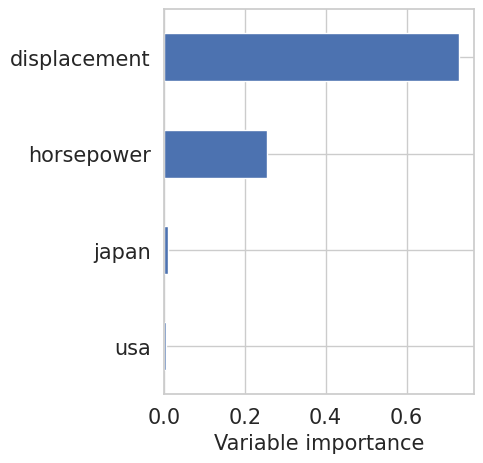

In [69]:
(pd.DataFrame(dict(cols=X_train.drop(columns='origin').columns, imp=model_rf.feature_importances_)).
 sort_values(by = 'imp').
 plot('cols', 'imp', 'barh', legend = False, figsize = (4,5)))

plt.ylabel('')
plt.xlabel('Variable importance', fontsize = 15)

plt.tick_params(labelsize = 15);

`displacement` and `horsepower` are the most important, with `displacement` contributing more to the model fit.

## Alternative linear regression models

### Quadratic model

Creating the design matrix for a quadratic model of both `displacement` and `horsepower` that includes interactions with `origin`.

In [70]:
X_design_train_2, X_design_test_2 = design_matrices('miles_per_gallon ~ (displacement  + horsepower + I(displacement**2) + I(horsepower**2)) * C(origin)',
                                                    df_train,
                                                    df_test)

In [71]:
X_design_train_2.head()

,Intercept,C(origin)[T.Japan],C(origin)[T.USA],displacement,displacement:C(origin)[T.Japan],displacement:C(origin)[T.USA],horsepower,horsepower:C(origin)[T.Japan],horsepower:C(origin)[T.USA],I(displacement ** 2),I(displacement ** 2):C(origin)[T.Japan],I(displacement ** 2):C(origin)[T.USA],I(horsepower ** 2),I(horsepower ** 2):C(origin)[T.Japan],I(horsepower ** 2):C(origin)[T.USA]
145,1.0,0.0,1.0,1.121011,0.0,1.121011,1.110412,0.0,1.110412,1.256666,0.0,1.256666,1.233014,0.0,1.233014
197,1.0,0.0,1.0,1.431488,0.0,1.431488,1.160889,0.0,1.160889,2.049157,0.0,2.049157,1.347662,0.0,1.347662
257,1.0,0.0,1.0,1.121011,0.0,1.121011,0.858027,0.0,0.858027,1.256666,0.0,1.256666,0.736210,0.0,0.736210
33,1.0,0.0,1.0,1.121011,0.0,1.121011,2.624720,0.0,2.624720,1.256666,0.0,1.256666,6.889155,0.0,6.889155
358,1.0,0.0,1.0,-0.948832,-0.0,-0.948832,-1.034859,-0.0,-1.034859,0.900282,0.0,0.900282,1.070932,0.0,1.070932


Fitting the model.

In [72]:
model_2 = sm.OLS(y_train, X_design_train_2).fit()

Printing the summary

In [73]:
print(model_2.summary()) #p<0.05 so variable is useful

                            OLS Regression Results                            
Dep. Variable:       miles_per_gallon   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     77.09
Date:                Wed, 25 Sep 2024   Prob (F-statistic):           1.23e-90
Time:                        22:31:51   Log-Likelihood:                -857.61
No. Observations:                 316   AIC:                             1745.
Df Residuals:                     301   BIC:                             1802.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [74]:
y_hat_2 = model_2.predict(X_design_train_2)

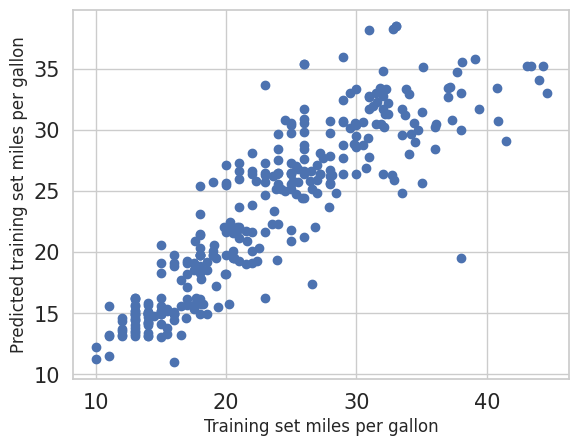

In [75]:
plt.plot(y_train, y_hat_2, 'o')

plt.xlabel('Training set miles per gallon', fontsize = 12)
plt.ylabel('Predicted training set miles per gallon', fontsize = 12)

plt.tick_params(labelsize = 15);

Predicting `y` in the test data and assessing the accuracy of the prediction.

In [76]:
y_predict_lr_2 = model_2.predict(X_design_test_2)

Plot of the test values of `y` vs. the predicted values

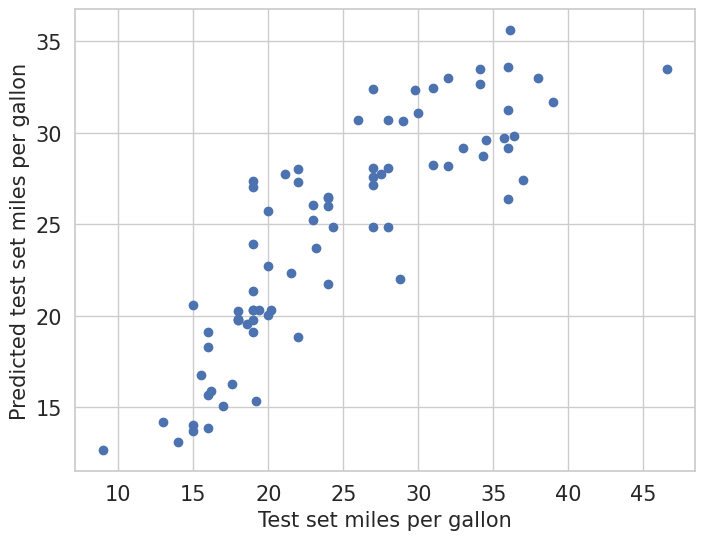

In [77]:
plt.figure(figsize = (8,6))

plt.plot(y_test, y_predict_lr_2, 'o');

plt.xlabel('Test set miles per gallon', fontsize = 15)
plt.ylabel('Predicted test set miles per gallon', fontsize = 15)

plt.tick_params(labelsize = 15)

Compute the RMSE

In [78]:
mean_squared_error(y_test, y_predict_lr_2, squared = False).round(3)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


4.01

Compute the mean absolute error

In [79]:
mean_absolute_error(y_test, y_predict_lr_2).round(3)

3.024

### Best subset selection

#### Best subset selection function

In [80]:
def best_subset_selection(X, y, k_folds=5):
    """ This function returns k-fold cross-validation RMSE values for use in best subset selection.
    It assumes that the input matrix X does NOT have a column of 1's. The intercept will be added.

    Inputs
    ------
    X : array-like, shape (n_samples, n_features)
        Predictor values

    y : array-like, shape (n_samples, )
        Target values

    Returns
    ------
    best_cv : k-fold RMSE for the best model at each number of possible predictors

    best_predictors : predictor names for the best model at each number of possible predictors

    """

    variable_names = X.columns.values

    number_variables = len(variable_names)

    # Initialize empty arrays to hold the k-fold cross-validated RMSE for the best model
    # at each number of predictors
    best_cv = np.zeros(number_variables)
    best_se = np.zeros(number_variables)

    # Initialize empty list to hold the names of the best predictors at each number of predictors

    best_predictors_cv = list()

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=1)
    kf.get_n_splits(X)

    # Loop over possible numbers of predictors
    for k in range(number_variables):

        # Get the names of all combinations of k+1 predictors
        subset_names = list(combinations(variable_names, k+1))

        # Loop over all models with k+1 predictors
        for n, predictor_names in enumerate(subset_names):

            # Fit the model
            predictors_subset = X.loc[:, predictor_names]

            model = sm.OLS(y, sm.add_constant(predictors_subset)).fit()

            cv_errors = np.zeros(kf.n_splits)
            # Do cross-validation
            for i, (train_index, test_index) in enumerate(kf.split(X)):
                model_cv = sm.OLS(y.iloc[train_index], sm.add_constant(predictors_subset.iloc[train_index,:])).fit()
                y_predict = model_cv.predict(sm.add_constant(predictors_subset.iloc[test_index,:]))
                cv_errors[i] = mean_squared_error(y.iloc[test_index], y_predict, squared = False)
            cv_rmse = cv_errors.mean()
            cv_se = cv_errors.std(ddof=1)/np.sqrt(k_folds)

            # Initialize the best values with the first model
            if n == 0:
                best_cv_k = cv_rmse
                best_predictors_cv_k = predictor_names
                best_se_k = cv_se

            # If a model has a better RMSE, update the best values
            elif cv_rmse < best_cv_k:
                best_cv_k = cv_rmse
                best_predictors_cv_k = predictor_names
                best_se_k = cv_se

        # Record the values for the best model at this number of predictors
        best_cv[k] = best_cv_k
        best_se[k] = best_se_k

        best_predictors_cv.append(best_predictors_cv_k)

    return best_cv, best_predictors_cv, best_se

In [81]:
def plot_best_subset_results(best_cv, best_se):
    """ Plot the best k-fold cv rmse at each number of possible predictors

    Input
    -----
    best_cv : k-fold RMSE for the best model at each number of possible predictors

    best_predictors : predictor names for the best model at each number of possible predictors

    """
    number_predictors = np.arange(len(best_cv))+1

    #plt.plot(number_predictors, best_cv, 'b-o')
    plt.errorbar(number_predictors, best_cv, best_se)
    plt.plot(number_predictors[np.argmin(best_cv)], np.min(best_cv), 'ro')
    plt.xticks(number_predictors)
    plt.xlabel('Number of predictors', fontsize=12)
    plt.ylabel('CV RMSE', fontsize=12)

    plt.subplots_adjust(wspace = 0.5, hspace=.5)

#### Performing best subset selection

In [82]:
best_cv, best_predictors_cv, best_se = best_subset_selection(X_design_train_2.drop(columns='Intercept'), y_train)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculat

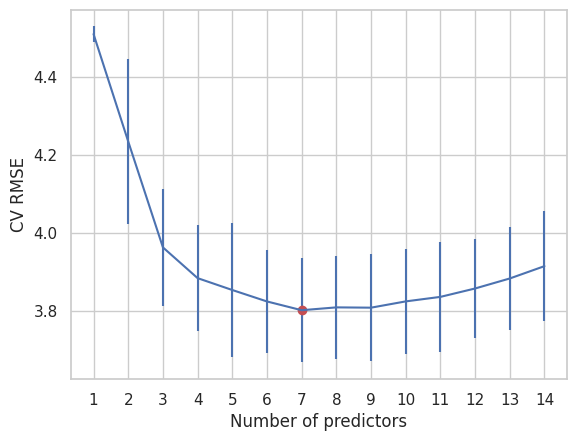

In [83]:
plot_best_subset_results(best_cv, best_se)

In [84]:
best_predictors_cv[np.argmin(best_cv)]

('C(origin)[T.Japan]',
 'displacement',
 'horsepower',
 'I(displacement ** 2)',
 'I(displacement ** 2):C(origin)[T.Japan]',
 'I(horsepower ** 2)',
 'I(horsepower ** 2):C(origin)[T.Japan]')

#### Fit the best subset model

Creating the design matrix for a quadratic model of both `displacement` and `horsepower` that includes interactions with `origin`.


In [85]:
X_design_train_3 = X_design_train_2[['Intercept', *best_predictors_cv[np.argmin(best_cv)]]]

X_design_test_3 = X_design_test_2[['Intercept', *best_predictors_cv[np.argmin(best_cv)]]]

In [86]:
X_design_train_3.head()

,Intercept,C(origin)[T.Japan],displacement,horsepower,I(displacement ** 2),I(displacement ** 2):C(origin)[T.Japan],I(horsepower ** 2),I(horsepower ** 2):C(origin)[T.Japan]
145,1.0,0.0,1.121011,1.110412,1.256666,0.0,1.233014,0.0
197,1.0,0.0,1.431488,1.160889,2.049157,0.0,1.347662,0.0
257,1.0,0.0,1.121011,0.858027,1.256666,0.0,0.736210,0.0
33,1.0,0.0,1.121011,2.624720,1.256666,0.0,6.889155,0.0
358,1.0,0.0,-0.948832,-1.034859,0.900282,0.0,1.070932,0.0


Fit the model.

In [87]:
model_3 = sm.OLS(y_train, X_design_train_3).fit()

Print the summary

In [88]:
print(model_3.summary())

                            OLS Regression Results                            
Dep. Variable:       miles_per_gallon   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     150.4
Date:                Wed, 25 Sep 2024   Prob (F-statistic):           1.99e-95
Time:                        22:45:01   Log-Likelihood:                -863.44
No. Observations:                 316   AIC:                             1743.
Df Residuals:                     308   BIC:                             1773.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [89]:
y_hat_3 = model_3.predict(X_design_train_3)

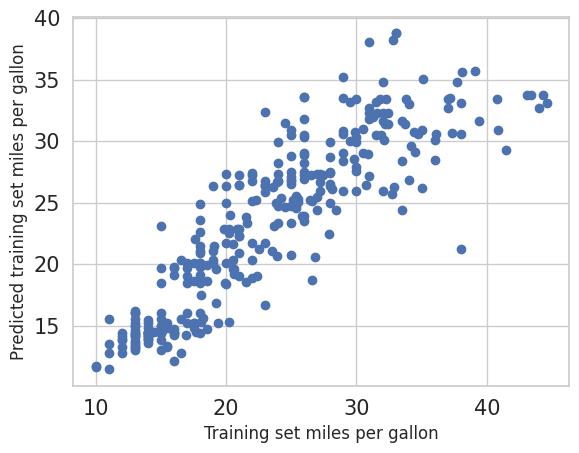

In [90]:
plt.plot(y_train, y_hat_3, 'o')

plt.xlabel('Training set miles per gallon', fontsize = 12)
plt.ylabel('Predicted training set miles per gallon', fontsize = 12)

plt.tick_params(labelsize = 15);

Predicting `y` in the test data and assess the accuracy of the prediction.

In [91]:
y_predict_lr_3 = model_3.predict(X_design_test_3)

Plotting the test values of `y` vs. the predicted values

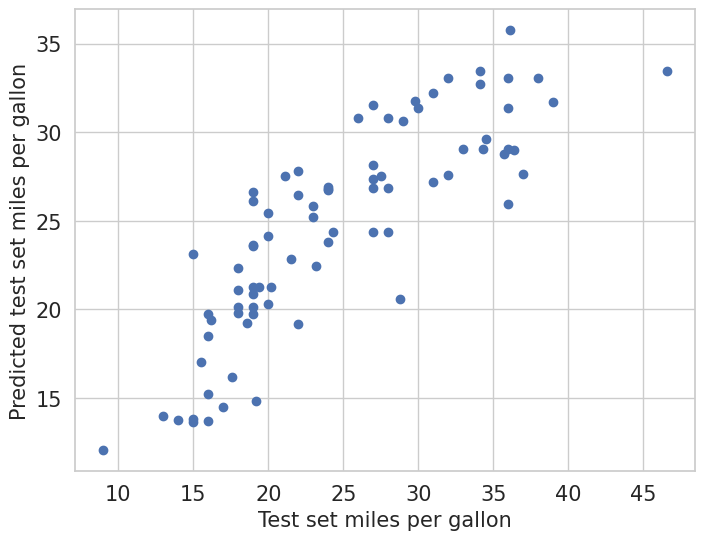

In [92]:
plt.figure(figsize = (8,6))

plt.plot(y_test, y_predict_lr_3, 'o');

plt.xlabel('Test set miles per gallon', fontsize = 15)
plt.ylabel('Predicted test set miles per gallon', fontsize = 15)

plt.tick_params(labelsize = 15)

Compute the RMSE

In [93]:
mean_squared_error(y_test, y_predict_lr_3, squared = False).round(3)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


4.202

Compute the mean absolute error

In [94]:
mean_absolute_error(y_test, y_predict_lr_3).round(3)

3.279

#### Fit the nearly best subset model

In [95]:
X_design_train_4 = X_design_train_2[['Intercept', *best_predictors_cv[4]]]

X_design_test_4 = X_design_test_2[['Intercept', *best_predictors_cv[4]]]

In [96]:
X_design_train_4.head()

,Intercept,C(origin)[T.Japan],displacement:C(origin)[T.USA],horsepower,horsepower:C(origin)[T.USA],I(displacement ** 2):C(origin)[T.USA]
145,1.0,0.0,1.121011,1.110412,1.110412,1.256666
197,1.0,0.0,1.431488,1.160889,1.160889,2.049157
257,1.0,0.0,1.121011,0.858027,0.858027,1.256666
33,1.0,0.0,1.121011,2.624720,2.624720,1.256666
358,1.0,0.0,-0.948832,-1.034859,-1.034859,0.900282


In [97]:
model_4 = sm.OLS(y_train, X_design_train_4).fit()

In [98]:
print(model_4.summary())

                            OLS Regression Results                            
Dep. Variable:       miles_per_gallon   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     208.3
Date:                Wed, 25 Sep 2024   Prob (F-statistic):           7.47e-97
Time:                        22:45:01   Log-Likelihood:                -865.57
No. Observations:                 316   AIC:                             1743.
Df Residuals:                     310   BIC:                             1766.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [99]:
y_hat_4 = model_4.predict(X_design_train_4)

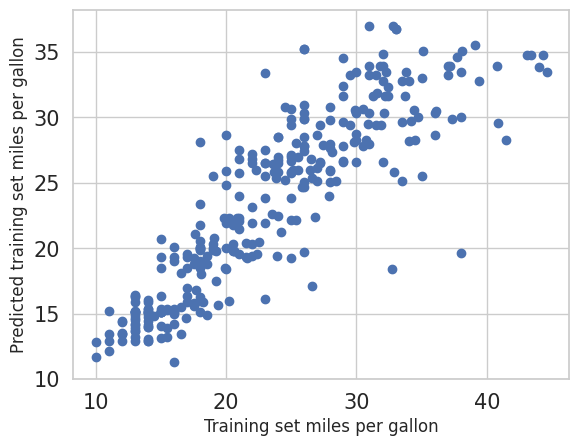

In [100]:
plt.plot(y_train, y_hat_4, 'o')

plt.xlabel('Training set miles per gallon', fontsize = 12)
plt.ylabel('Predicted training set miles per gallon', fontsize = 12)

plt.tick_params(labelsize = 15);

Predicting `y` in the test data and assess the accuracy of the prediction.

In [101]:
y_predict_lr_4 = model_4.predict(X_design_test_4)

Plot of the test values of `y` vs. the predicted values

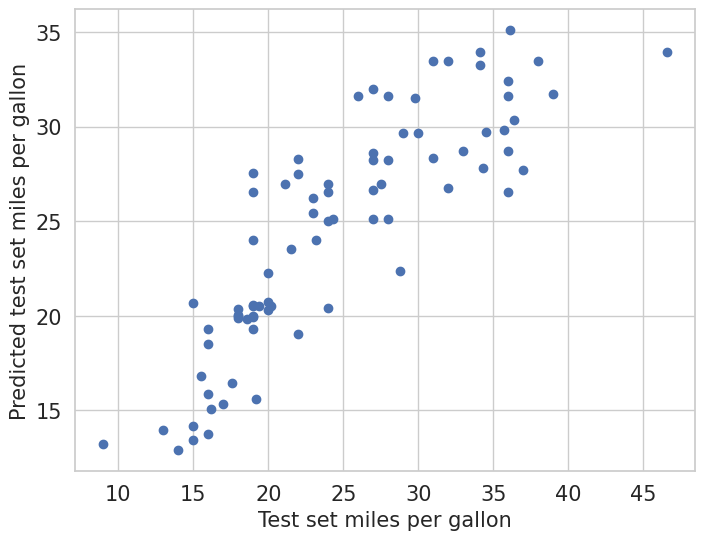

In [102]:
plt.figure(figsize = (8,6))

plt.plot(y_test, y_predict_lr_4, 'o');

plt.xlabel('Test set miles per gallon', fontsize = 15)
plt.ylabel('Predicted test set miles per gallon', fontsize = 15)

plt.tick_params(labelsize = 15)

Compute the RMSE

In [103]:
mean_squared_error(y_test, y_predict_lr_4, squared = False).round(3)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3.989

Compute the mean absolute error

In [104]:
mean_absolute_error(y_test, y_predict_lr_4).round(3)

3.05

# Evaluation

The analysis suggests that measures of a car's power, horsepower and displacement are related to the fuel efficiency of a car measured in the miles per gallon.

Additionally, cars made in the USA have a different relationship between a car's power and the fuel efficiency than the relatioonship seen in cars made in Japan and Europe.

Both horsepower and displacement are useful in predicting the fuel efficiency even though they are correlated variables.

A quadratic model captures most of the structure seen in this data set.

With this model, we can predict miles per gallon to roughly 3 miles per gallon.
